# Optimising Character Classification Network

## Import

In [1]:
from lab3.nn_general import NeuralNetwork
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
import pandas as pd

## Function Definition

In [2]:
def train(data, nn):
    # Train the neural network on each trainingsample
    for record in data:

        # Split the record by the commas
        pixelValues = record.split(',')
        label = pixelValues.pop(0)

        # Scale and shift the inputs from 0..255 to 0.01..1
        inputs = (np.asfarray(pixelValues) / 255.0 * 0.99) + 0.01

        # Create the target output values (all 0.01, except the desired label which is 0.99)
        targets = np.zeros(nn.output_nodes) + 0.01

        # pixelValues[0] is the target label for this record
        targets[int(label)] = 0.99

        # Train the network
        nn.train(inputs.tolist(), targets.tolist())
        
    return nn

In [3]:
def test(data, nn):
    
    scorecard = []
    successRate = 0
    
    for record in data:
        # Split the record by commas
        pixelValues = record.split(',')

        # Correct label is the first value
        correct_label = int(pixelValues.pop(0))

        # Scale and shift the inputs
        inputs = (np.asfarray(pixelValues)/255.0*0.99) + 0.01

        # Query the network
        outputs = nn.queryNN(inputs.tolist())

        # Identify predicted label
        prediction = np.argmax(outputs)

        # Add to scorecard
        if prediction == correct_label:
            scorecard.append(1)
        else:
            scorecard.append(0)
            
    scorecard = np.asarray(scorecard)
    successRate = (scorecard.sum()/scorecard.size)*100
    return nn, successRate

## Load len(500) Training Dataset

Get training data

In [8]:
file = open("datasources\\fashion_mnist_train_1000.csv", 'r')
data_training = file.readlines()
file.close()

Get test data

In [9]:
file = open("datasources\mnist_test_100.csv", 'r')
data_testing = file.readlines()
file.close()

## Set Parameters

Specify nn parameters to use

In [10]:
x_hidden_nodes = [50, 75, 100, 200, 300, 500, 700, 900, 1100]
lrs = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

Create new dict to store results

In [11]:
results = {}

## Iterate Hidden Nodes and LR Over Train/ Test Loop

In [12]:
# Loop through each number of hidden nodes
for hidden_nodes in tqdm(x_hidden_nodes):
    data = {}
    
    # Loop through each learning rate
    for lr in lrs:
        # Create new nn
        nn = NeuralNetwork(input_nodes=784, 
                           hidden_nodes=hidden_nodes, 
                           output_nodes=10, 
                           lr=lr)
        
        # Train that nn 10 times (epochs)
        for i in range(10):
            nn = train(data_training, nn)
            
        # Test that nn, return also successRate
        nn, successRate = test(data_testing, nn)
        
        # Store success rate *for that lr* in a dict
        data[lr] = successRate
        
    # Store in dict containing success scores for each lr *for that number of hidden nodes* 
    results[str(hidden_nodes)] = data

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [46:43<00:00, 311.44s/it]


## Plot Results

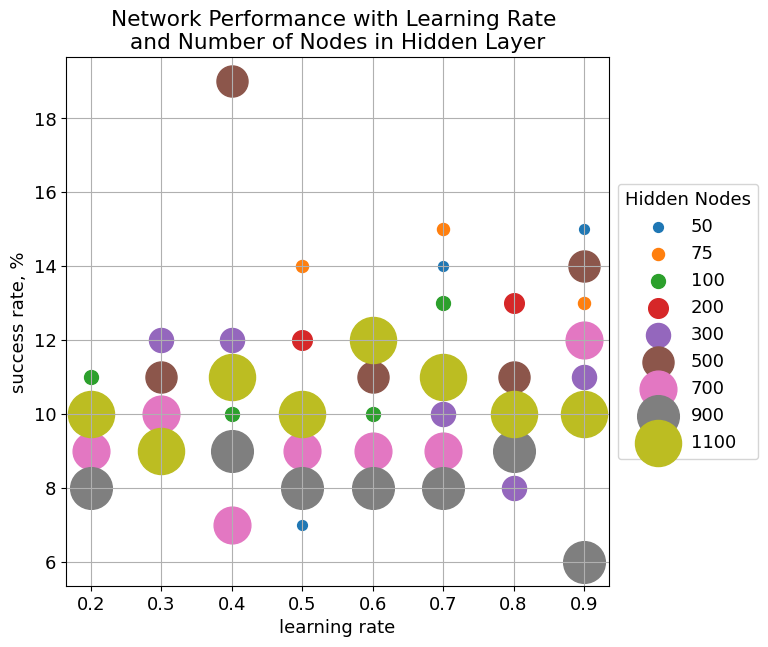

In [13]:
fig = plt.figure(figsize=[7, 7], dpi=100)
ax1 = fig.add_subplot()

ax1.set_xlabel('learning rate')
ax1.set_ylabel('success rate, %')
ax1.set_title('Network Performance with Learning Rate \nand Number of Nodes in Hidden Layer')

for i in results.keys():
    x = results[i].keys()
    y = results[i].values()
    ax1.scatter(x, y, label=i, s=int(i))

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Hidden Nodes')
ax1.grid(True)

In [ ]:
for i in results.keys():
    bestResult = max(results[i], key=lambda y: abs(results[i][y]))
    print(i, bestResult)

## Select Best Performers for Further Training

Create df because dataframes are nice

In [ ]:
data_performance = pd.DataFrame(results)
data_performance

Select best 3 number of hidden nodes for each LR and sort by performance

In [ ]:
selected = pd.DataFrame()

for col in data_performance.columns:
    # Get and sort column values as series
    values = data_performance[col].sort_values(ascending=False)
    # Select top three performers
    tops = vals.iloc[:3]
    
    # Form into suitable df and append
    df = pd.DataFrame(tops)
    df.reset_index(level=0, inplace=True)
    df.columns = ['learningRates','performance']
    df['hiddenNodes'] = col
    selected = selected.append(df, ignore_index=True)
    
selected.sort_values(by='performance', ascending=False, inplace=True, ignore_index=True)
selected

## Retrain with More Data and Epochs

Get training data with 1k lines instead of 500. (use same test dataset of 100 lines)

In [ ]:
file = open("datasources\mnist_train_1000.csv", 'r')
data_training = file.readlines()
file.close()

Loop through each selected LR/ Hidden nodes combo and train a NN with 50 epochs instead of 10

In [ ]:
selected = pd.read_excel('.\datasources\selected.xlsx', index_col=0)
selected

In [ ]:
for index, row in tqdm(selected.iterrows()):
    # Create new nn
    nn = NeuralNetwork(input_nodes=784, 
                       hidden_nodes=int(row['hiddenNodes']), 
                       output_nodes=10, 
                       lr=float(row['learningRates']))

    # Train that nn 50 times (epochs)
    for i in range(50):
        nn = train(data_training, nn)

    # Test that nn, return also successRate
    nn, successRate = test(data_testing, nn)

    # Store success rate *for that lr* in a dict
    selected.at[index, 'performanceUpdated'] = successRate

In [ ]:
selected.sort_values(by='performanceUpdated', ascending=False)

In [ ]:
selected.nlargest(8, 'performanceUpdated')